In [17]:
from torch.utils.data import DataLoader
import torch
from torch import nn, optim
from dataset import CXR_dataset, train_dataset,val_dataset
from transformers import AutoModel, AutoProcessor, AutoConfig
from model import CheXagentSigLIPBinary
from utils import train_one_epoch, validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, precision_recall_curve

In [2]:
MODEL_NAME = "StanfordAIMI/XraySigLIP__vit-l-16-siglip-384__webli"
device = "cuda" if torch.cuda.is_available() else "cpu"
dtype = torch.float32

In [3]:
config = AutoConfig.from_pretrained(
    MODEL_NAME,
    trust_remote_code=True
)
vision_full = AutoModel.from_pretrained(
    MODEL_NAME,
    config=config,
    trust_remote_code=True
).to(device, dtype)
vision_encoder = vision_full.vision_model
del vision_full

/home/jupyter-nafisha/.local/lib/python3.12/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [7]:
checkpoint_path= '/home/jupyter-nafisha/normal-abnormal-chexagent-attention-loss/main/best_model.pth'
model = CheXagentSigLIPBinary(vision_encoder= vision_encoder)
ckpt = torch.load(checkpoint_path, map_location="cpu")
model.load_state_dict(ckpt['model_state'])
model.to(device)
model.eval()

CheXagentSigLIPBinary(
  (vision_encoder): SiglipVisionTransformer(
    (embeddings): SiglipVisionEmbeddings(
      (patch_embedding): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16), padding=valid)
      (position_embedding): Embedding(1024, 1024)
    )
    (encoder): SiglipEncoder(
      (layers): ModuleList(
        (0-23): 24 x SiglipEncoderLayer(
          (self_attn): SiglipAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (layer_norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (mlp): SiglipMLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=1024, out_features=4096, bias=True)
            (fc2): Linear(in_features=4096, out_fe

In [8]:
img_dir = ''
test_csv = '/home/jupyter-nafisha/normal-abnormal-chexagent-attention-loss/CSV/test.csv'

In [10]:
test_dataset = CXR_dataset(test_csv, img_dir, transform=None)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=32)

In [11]:
true_labels = test_dataset.df["label"].map({"Normal": 0, "Abnormal": 1}).tolist()
image_names = test_dataset.df["image_id"].tolist()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


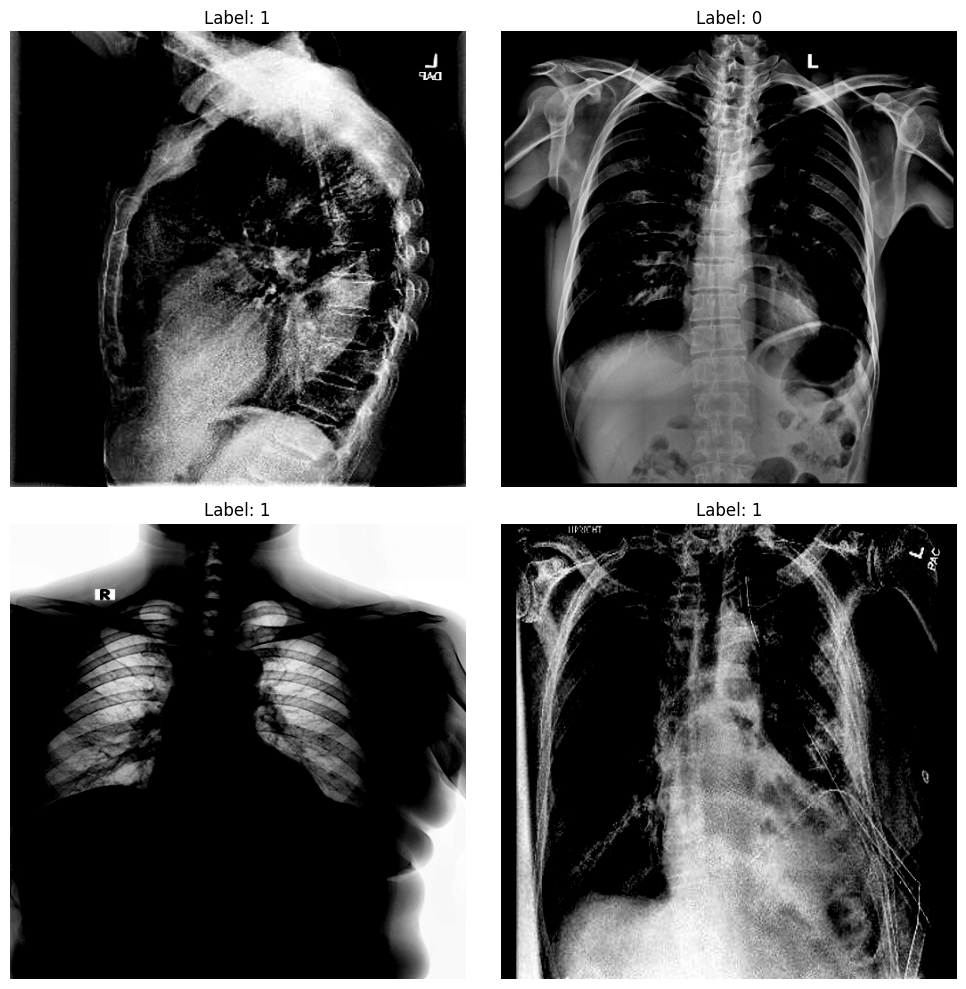

In [13]:
import matplotlib.pyplot as plt
import torch

# Get one batch
for images, label, _, _ in test_loader:
    break  # only take the first batch

# Plot 16 images in a 4x4 grid
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()

for i in range(4):
    img = images[i].permute(1, 2, 0)  # C,H,W → H,W,C
    axes[i].imshow(img)
    axes[i].axis("off")
    axes[i].set_title(f"Label: {label[i].item()}")

plt.tight_layout()
plt.show()

In [46]:
predictions = []
probabilities = []
true_labels = [] 
count = 0
with torch.no_grad():
    for images, label, _, _ in test_loader:  
        images = images.to(device)
        label = label.to(device)

        logits,_ = model(images)             # shape: (B, 1)
        probs = torch.sigmoid(logits).squeeze(1)      # shape: (B,)

        preds = (probs >= 0.5).long()      # thresholding for binary prediction

        probabilities.extend(probs.cpu().numpy())
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(label.cpu().numpy())

        if count%100==0:
            print("step:- ", count)
        count+=1

step:-  0
step:-  100
step:-  200
step:-  300
step:-  400
step:-  500
step:-  600
step:-  700
step:-  800
step:-  900
step:-  1000
step:-  1100
step:-  1200
step:-  1300
step:-  1400
step:-  1500
step:-  1600
step:-  1700


In [47]:
type(true_labels[0]), type(predictions[0])

(numpy.int64, numpy.int64)

In [48]:
# predictions

In [49]:
acc = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions)
recall = recall_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions)
cm = confusion_matrix(true_labels, predictions)

tn, fp, fn, tp = cm.ravel()
# Specificity
specificity = tn / (tn + fp)

In [50]:
print("\n==== Evaluation Metrics ====")
print(f"Accuracy     :  {acc:.4f}")
print(f"Precision    :  {precision:.4f}")
print(f"Recall       :  {recall:.4f}")
print(f"Specificity  :  {specificity:.4f}")
print(f"F1 Score     :  {f1:.4f}")
print("\nConfusion Matrix:")
print(cm)


==== Evaluation Metrics ====
Accuracy     :  0.8020
Precision    :  0.7736
Recall       :  0.8705
Specificity  :  0.7293
F1 Score     :  0.8192

Confusion Matrix:
[[2532  940]
 [ 478 3212]]


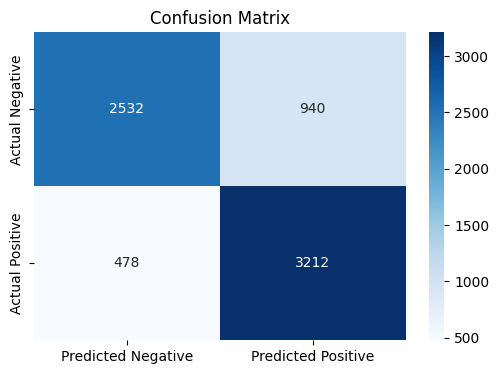

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Create confusion matrix
cm = np.array([[tn, fp],
               [fn, tp]])

# Plot
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Predicted Negative", "Predicted Positive"],
            yticklabels=["Actual Negative", "Actual Positive"])
plt.title("Confusion Matrix")
plt.show()

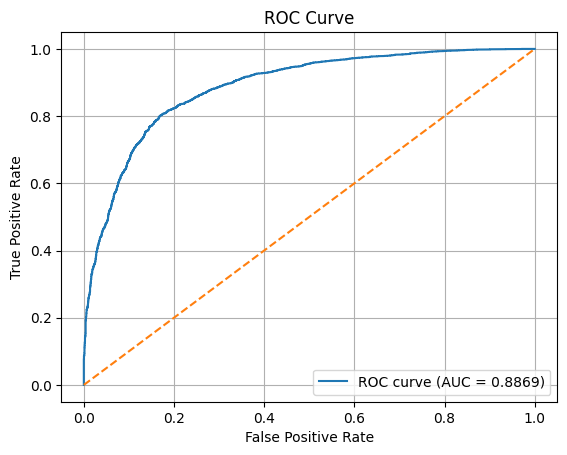

In [53]:
fpr, tpr, roc_thresholds = roc_curve(true_labels, probabilities)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--')  # random baseline
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

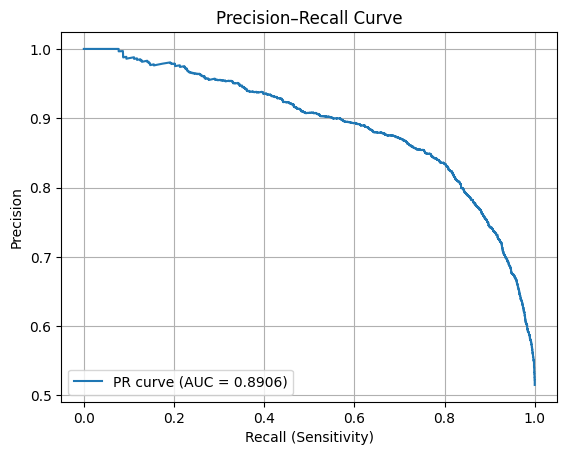

In [54]:
precision, recall, pr_thresholds = precision_recall_curve(true_labels, probabilities)
pr_auc = auc(recall, precision)

plt.figure()
plt.plot(recall, precision, label=f'PR curve (AUC = {pr_auc:.4f})')
plt.xlabel('Recall (Sensitivity)')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()
